In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [68]:
# Define the path to the MadGraph directory
path_to_madgraph = os.path.expanduser('~/Development/MG5_aMC_v3_5_0')  # Change this to your MadGraph installation path
notebook_path = os.getcwd( )

# Change the current directory to the MadGraph directory
os.chdir(path_to_madgraph)

# Create a command file with all the instructions for MadGraph
mg5_commands = """
import model ExoticMuonCaptureModel1
generate pp mu- > vm chi1 e+ e- QEDp=10 QED=4
output MuonCaptureModel1
launch MuonCaptureModel1
set ptl -1
set etal -1
set etalmin -1
set drll -1
set nevents 50000
set ebeam1 0.00001
set ebeam2 0.00001
"""

# Save the commands to a file
with open('mg5_script.txt', 'w') as file:
    file.write(mg5_commands)

# Run the MadGraph script
os.system(f'{path_to_madgraph}/bin/mg5_aMC mg5_script.txt')

# Return to the current notebook
os.chdir(notebook_path)

************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.0                 2023-05-12         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: stdin isn't a terminal


compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_ppmum_vlchi1epem  
GC_5 GC_6 GC_8 GC_9 GC_11
This will slow down the computation. Please consider using restricted model:
https://answers.launchpad.net/mg5amcnlo/+faq/2312 
INFO:     P1_ppmum_vlchi1epem  


100%|██████████| 774/774 [00:00<00:00, 51021.43it/s]


INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 20h52 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.36s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.36s  ] 
INFO: End survey 
refine 50000
Creating Jobs
INFO: Refine results to 50000 
INFO: Generating 50000.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 0.003779765654529419 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 15874000.0 +- 470030.0
    P1_ppmum_vlchi1epem 
INFO:  Idle: 52,  Running: 8,  Completed: 0 [ current time: 20h52 ] 
INFO:  Idle: 43,  Running: 8,  Completed: 9 [  3.2s  ] 
INFO:  Idle: 27,  Running: 8,  Completed: 25 [  7s  ] 
INFO:  Idle: 11,  Running: 8,  Completed: 41 [  10.8s  ] 
INFO:  Idle: 0,  Running: 3,  Completed: 57 [  13.9s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 60 [  14s  ] 
INFO: Combining runs 
sum of cpu time of last step: 1m40s
INFO: finish refine 
refine 50000 --treshold=0.9
No need for second refine due

In [69]:
import gzip
import shutil

# Move the LHE events to the desired path
lhe_file_path = f'{path_to_madgraph}/MuonCaptureModel1/Events/run_01/unweighted_events.lhe.gz'
destination_path = os.path.expanduser(notebook_path+'/MGevents/')
os.makedirs(destination_path, exist_ok=True)  # Make sure the destination directory exists


# Specify the source and destination paths
source_path = lhe_file_path
destination_path = os.path.join(destination_path, 'unweighted_events.lhe.gz')

# Copy the file from the source to the destination
shutil.copyfile(source_path, destination_path)

# Specify the path for the unzipped LHE file
unzipped_file_path = destination_path.replace('.gz', '')

# Open the zipped file and the unzipped file
with gzip.open(destination_path, 'rb') as f_in:
    with open(unzipped_file_path, 'wb') as f_out:
        # Copy the contents from the zipped file to the unzipped file
        f_out.write(f_in.read())


In [70]:
import numpy as np
import pylhe 


def get_P_and_id_from_MG5(filename):
    mg5events = pylhe.read_lhe_with_attributes(filename)

    # Create akward array objects for convinience
    mg5events = pylhe.to_awkward(mg5events)

    return mg5events

In [71]:
mg5events = get_P_and_id_from_MG5(unzipped_file_path)

In [72]:
# Calculate the total energy
electrons = (mg5events['particles', 'id'] == 11)
positrons = (mg5events['particles', 'id'] == -11)
neutrinos = (np.abs(mg5events['particles', 'id']) == 12) | (np.abs(mg5events['particles', 'id']) == 14)
chi1s = (np.abs(mg5events['particles', 'id']) == 999901)

Etot_electrons = mg5events['particles','vector','t'][electrons].to_numpy().sum(axis=1)
Etot_positrons = mg5events['particles','vector','t'][positrons].to_numpy().sum(axis=1)
Etot_neutrinos = mg5events['particles','vector','t'][neutrinos].to_numpy().sum(axis=1)
Etot_chi1s = mg5events['particles','vector','t'][chi1s].to_numpy().sum(axis=1)

Evis = Etot_positrons + Etot_electrons
Tvis = Evis - 2*0.511e-3
Einv = Etot_neutrinos + Etot_chi1s

In [73]:
from Mu3e import const, plot_tools

def get_xsec_in_rate(gamma):
    return const.get_decay_rate_in_s(gamma)

Lambda_NP = 1e4 # 10 TeV / 1 GeV
gD = 1e-4 # gD = 1e-3
rescale = 1/ Lambda_NP**2
weights = mg5events['eventinfo','weight'].to_numpy() * rescale * len(mg5events)

def Gamma_Ap(gD, maprime):
    g = gD**2 / 4/ np.pi * maprime/3
    return const.get_decay_rate_in_cm(g)

Gamma_Ap(1e-4, 0.02)

0.0037195259527083367

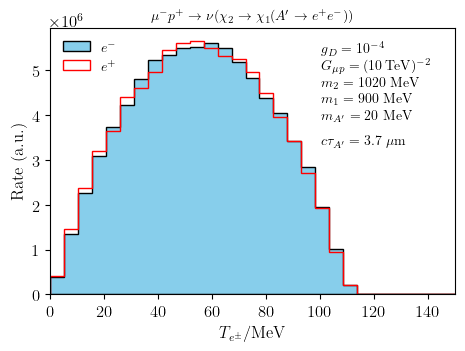

In [174]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, 150, 30)
ax.hist(Etot_electrons*1e3 - 0.511, weights=weights/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='$e^-$')

# Plot the histogram
bins = np.linspace(0, 150, 30)
ax.hist(Etot_positrons*1e3 - 0.511, weights=weights/np.diff(bins)[0], bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$T_{e^\pm}$/MeV')
ax.set_ylabel(r'Rate (a.u.)')
ax.set_title(fr'$\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))$', fontsize=10)

# ax.set_yscale('log')
ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_box = r'\noindent$g_D = 10^{-4}$\\$G_{\mu p} = (10 \, {\rm TeV})^{-2}$\\$m_2 = 1020$ MeV\\$m_1 = 900$ MeV\\$m_{A^\prime} = 20$ MeV'
ax.text(0.67, 0.95, text_box, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.67, 0.6, fr'$c\tau_{{A^\prime}} = {Gamma_Ap(1e-4, 0.02)*1e3:.1f}$~$\mu$m', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.legend(loc='upper left', fontsize=10, frameon=False)

# Add the vertical dashed line
# mp = 938.27
# mmu = 105.66 
# mchi1 = 900 
# mchi2 = 1020
# me = 0.511
# maprime = 20
# sqrts = (mp + mmu)
# Echi2_CM = (sqrts**2 + mchi2**2)/2/sqrts
# Echi1_max = (sqrts**2 + mchi1**2 - (2*me)**2)/2/sqrts
# Ee_max = (Echi2_CM**2 + me**2 - (me + mchi1)**2)/2/Echi2_CM
# cutoff = Ee_max
# ax.axvline(cutoff, linestyle='dashed', color='grey', alpha=0.2)
# ax.text(cutoff+2, ax.get_ylim()[1]/20, r'$\frac{ E_{\chi_2}^{\rm CM\,2} + m_e^2 - (m_e + m_1)^2}{2E^{\rm CM}_{\chi_2}}$', rotation='vertical', color='grey', ha='left', va='bottom')


# Save the figure to a PDF file
fig.savefig('plots/MuonCapture_model1.png', bbox_inches='tight', dpi=300)

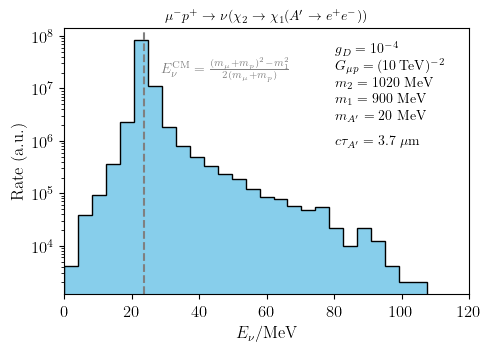

In [175]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, 120, 30)
ax.hist(Etot_neutrinos*1e3, weights=weights/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='electron')

# Set labels and title
ax.set_xlabel(r'$E_{\mathrm{\nu}}$/MeV')
ax.set_ylabel(r'Rate (a.u.)')
ax.set_title(fr'$\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))$', fontsize=10)

ax.set_yscale('log')
ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_box = r'\noindent$g_D = 10^{-4}$\\$G_{\mu p} = (10 \, {\rm TeV})^{-2}$\\$m_2 = 1020$ MeV\\$m_1 = 900$ MeV\\$m_{A^\prime} = 20$ MeV'
ax.text(0.67, 0.95, text_box, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.67, 0.6, fr'$c\tau_{{A^\prime}} = {Gamma_Ap(1e-4, 0.02)*1e3:.1f}$~$\mu$m', transform=ax.transAxes, fontsize=10, verticalalignment='top')


# Add the vertical dashed line
Enu_CM = (sqrts**2 - mchi2**2)/2/sqrts
cutoff = Enu_CM
ax.axvline(cutoff, linestyle='dashed', color='grey')
ax.text(cutoff+5, ax.get_ylim()[1]/10, r'$E_\nu^{\rm CM} = \frac{ (m_\mu + m_p)^2 - m_1^2}{2(m_\mu + m_p)}$', rotation='horizontal', color='grey', ha='left', va='bottom')


# Save the figure to a PDF file
fig.savefig('plots/MuonCapture_model1_neutrino.png', bbox_inches='tight', dpi=300)

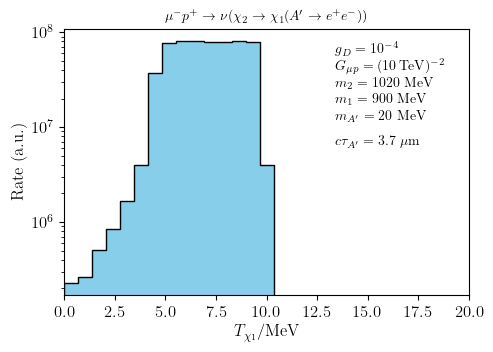

In [176]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, 20, 30)
ax.hist(Etot_chi1s*1e3 - 900, weights=weights/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='electron')

# Set labels and title
ax.set_xlabel(r'$T_{\chi_1}$/MeV')
ax.set_ylabel(r'Rate (a.u.)')
ax.set_title(fr'$\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))$', fontsize=10)

ax.set_yscale('log')
ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_box = r'\noindent$g_D = 10^{-4}$\\$G_{\mu p} = (10 \, {\rm TeV})^{-2}$\\$m_2 = 1020$ MeV\\$m_1 = 900$ MeV\\$m_{A^\prime} = 20$ MeV'
ax.text(0.67, 0.95, text_box, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.67, 0.6, fr'$c\tau_{{A^\prime}} = {Gamma_Ap(1e-4, 0.02)*1e3:.1f}$~$\mu$m', transform=ax.transAxes, fontsize=10, verticalalignment='top')


# Add the vertical dashed line
# Echi1_max = (Echi2_CM**2 + mchi1**2 - (maprime)**2)/2/Echi2_CM - 900
# cutoff = Echi1_max
# ax.axvline(cutoff, linestyle='dashed', color='grey')
# ax.text(cutoff+1, ax.get_ylim()[1]/10, r'$m_p + m_\mu - m_2$', rotation='horizontal', color='grey', ha='left', va='bottom')


# Save the figure to a PDF file
fig.savefig('plots/MuonCapture_model1_chi1.png', bbox_inches='tight', dpi=300)

In [164]:
Echi1_max

6.893195906387177

In [103]:
cutoff

123.93000000000006